In [306]:
import pandas as pd
import plotnine as pn
import patchworklib as pw
print(pw.__version__)
print(pn.__version__)

0.5.0
0.8.0


## Read data

In [307]:
# # Filepaths

# filepaths = [
#     'half_credit_literal',
#     'indicator_literal',
#     'half_credit_pragmatic',
#     'indicator_pragmatic',
# ]

# get_fp = lambda setting: f'../../outputs/journal/{setting}/analysis/all_data.csv'
# filepaths = {key: get_fp(key) for key in filepaths}

In [308]:
settings = [
    'uniform_half_credit_literal',
    'uniform_indicator_literal',
    'uniform_half_credit_pragmatic',
    'uniform_indicator_pragmatic',
    'estimated_half_credit_literal',
    'estimated_indicator_literal',
    'estimated_half_credit_pragmatic',
    'estimated_indicator_pragmatic',
]
filepaths = {setting: f'{setting}.csv' for setting in settings }

In [309]:
# Load dataframes

# half_credit_literal_data = pd.read_csv(filepaths['half_credit_literal'])
# indicator_literal_data = pd.read_csv(filepaths['indicator_literal'])
# half_credit_pragmatic_data = pd.read_csv(filepaths['half_credit_pragmatic'])
# indicator_pragmatic_data = pd.read_csv(filepaths['indicator_pragmatic'])

In [310]:
uniform_half_credit_literal_data = pd.read_csv(filepaths['uniform_half_credit_literal'])
estimated_half_credit_literal_data = pd.read_csv(filepaths['estimated_half_credit_literal'])

uniform_indicator_literal_data = pd.read_csv(filepaths['uniform_indicator_literal'])
estimated_indicator_literal_data = pd.read_csv(filepaths['estimated_indicator_literal'])

uniform_half_credit_pragmatic_data = pd.read_csv(filepaths['uniform_half_credit_pragmatic'])
estimated_half_credit_pragmatic_data = pd.read_csv(filepaths['estimated_half_credit_pragmatic'])

uniform_indicator_pragmatic_data = pd.read_csv(filepaths['uniform_indicator_pragmatic'])
estimated_indicator_pragmatic_data = pd.read_csv(filepaths['estimated_indicator_pragmatic'])

## Generate multiplot

##### sanity check plots first

In [311]:
def get_plot(input_data):

    data = input_data.copy() # this helps

    pareto_data = data[data["dominant"] == True]
    natural_data = data[data["natural"] == True]

    og_data = data.copy()
    subset = ["complexity", "comm_cost"]
    vcs = data.value_counts(subset=subset, sort=False)
    data = og_data.drop_duplicates(subset=subset)  # drop dupes from original
    data = data.sort_values(by=subset)
    data["counts"] = vcs.values

    # aesthetics for all data
    kwargs = {
        "color": "iff",
        "size": "counts",
    }

    plot = (
        # Set data and the axes
        pn.ggplot(mapping=pn.aes(x="complexity", y="comm_cost"))
        # + pn.scale_y_continuous(limits=[0, 1])
        + pn.geom_point(data=pareto_data)
        + pn.geom_point(  # all langs
            data=data,
            stroke=0,
            alpha=1,
            mapping=pn.aes(**kwargs),
        )
        # + pn.xlab("Complexity")
        # + pn.ylab("Communicative cost")
        + pn.scale_color_cmap("cividis")
        + pn.theme_classic()
    )
    if natural_data is not None:
        plot = (
            plot
            + pn.geom_point(  # The natural languages
                natural_data,
                color="red",
                shape="+",
                size=4,
            )
            # + pn.geom_text(
            #     natural_data,
            #     pn.aes(label="name"),
            #     ha="left",
            #     size=6,  # orig 9
            #     nudge_x=1,
            # )
        )
    return plot

### define individual subplots

In [312]:
# First: Upper left
ehcl_plot = (
    get_plot(estimated_half_credit_literal_data)
#     + pn.ggtitle("Literal Agents")
#     + pn.ylab("Graded Communicative Utility")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                # plot_title=pn.element_text(margin={"t":0, "b":150, "l":0, "r":0}),
                # axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )
)

# Second
ehcp_plot = (
    get_plot(estimated_half_credit_pragmatic_data)
#     + pn.ggtitle("Pragmatic Agents")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                # plot_title=pn.element_text(margin={"t":0, "b":200, "l":0, "r":20}),
        )
)

# Third
uhcl_plot = (
    get_plot(uniform_half_credit_literal_data)
#     + pn.ggtitle("Literal Agents")
#     + pn.ylab("Graded Communicative Utility")
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                # plot_title=pn.element_text(margin={"t":0, "b":200, "l":0, "r":0}),
                # axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
                axis_title_y=pn.element_blank(),
        )
)

# Fourth: Upper right
uhcp_plot = (
    get_plot(uniform_half_credit_pragmatic_data)
#     + pn.ggtitle("Pragmatic Agents")
    + pn.theme(
                figure_size=(12, 9),
                # legend_position=(2., -1.),
                legend_position='none',
                legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                # plot_title=pn.element_text(margin={"t":0, "b":200, "l":20, "r":0}),
        )
)

# Fifth: Lower left
eil_plot = (
    get_plot(estimated_indicator_literal_data)
#     + pn.ylab("Binary Communicative Utility")    
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
                # axis_title_y=pn.element_text(margin={"t":0, "b":0, "l":0, "r":20})
        )        
)

# Sixth
eip_plot =  (
    get_plot(estimated_indicator_pragmatic_data) 
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
        )
)

# Seventh
uil_plot = (
    get_plot(uniform_indicator_literal_data)
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='vertical',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),                
        )        
)

# Eighth: lower right
uip_plot =  (
    get_plot(uniform_indicator_pragmatic_data) 
    + pn.theme(
                figure_size=(12, 9),
                legend_position='none',
                # legend_box='horizontal',
                # legend_title_align='center',
                axis_title_x=pn.element_blank(),
                axis_title_y=pn.element_blank(),
        )
)

#### Stitch together multiplot with patchworklib

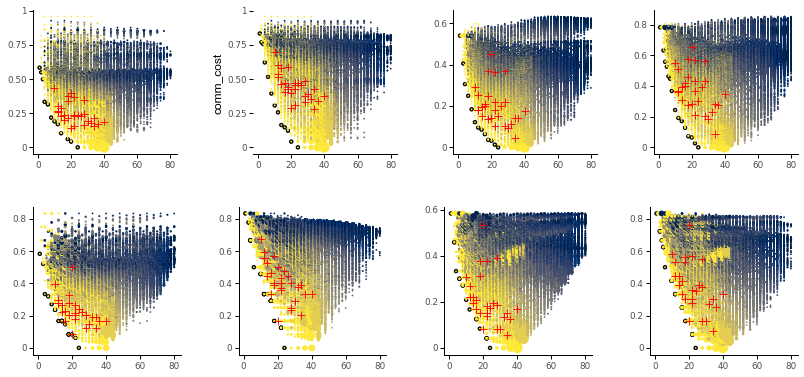

In [313]:
g_ehcl = pw.load_ggplot(ehcl_plot, figsize=(2,2))
g_ehcp = pw.load_ggplot(ehcp_plot, figsize=(2,2))
g_uhcl = pw.load_ggplot(uhcl_plot, figsize=(2,2))
g_uhcp = pw.load_ggplot(uhcp_plot, figsize=(2,2))

g_eil = pw.load_ggplot(eil_plot, figsize=(2,2))
g_eip = pw.load_ggplot(eip_plot, figsize=(2,2))
g_uil = pw.load_ggplot(uil_plot, figsize=(2,2))
g_uip = pw.load_ggplot(uip_plot, figsize=(2,2))


# g = (g_ehcl | g_ehcp | g_uhcl | g_uhcp) / (g_eil | g_eip | g_uil | g_uip)
# g = (g_ehcl | g_uhcl | g_ehcp | g_uhcp) / (g_eil | g_eip | g_uil | g_uip)

# top row is estimated, bottom row is uniform
g = ( g_ehcl | g_eil | g_ehcp | g_eip ) / ( g_uhcl | g_uil | g_uhcp | g_uip )

g.savefig("multiplot.png")